# Predicting Customers Churn

Idea from [Yhat](http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html), then modified by Hassen Taidirt to include business considerations.

***

In this notebook, I'll try to predict customers churn, in a business perspective to reduce churn costs. I started with this blog post from [Yhat](http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html) then I modified their study because they didn't included business considerations in their predictions.

The goal is not only to predict which customer is more likely to churn. _Why_ do we want to predict customers churn? To reduce loss. Here, there is an implicit business goal. The predictive model doesn'r only need to preduct customers at risk but also reduce the company loss due to churns. That's what I do in this notebook, which is not covered in the original Yhat blog post (in fact, there is a mention of this business perspective, but no additional details were provided).

I will load a customers database of a telecom company and preprocess it before study. Then, I will discuss some modeling considerations that are specific to this database. Next, I will build few models and tweak them to find the best predictor that reduces costs. Finally, a conclusion that will also summarize learned lessons will close this notebook.

Here we go!

_Nota:_ Please note that I'm not going to define any business term until this is useful for the study. This is out of the scope of our study goal which is to show how to apply Predictive Modeling in a business context. Please refer to wikipedia/google if needed, or just email me at: htaidirt [at] gmail [dot] com

***

## Step 0: Preparation and data load

Nothing exciting here, only loading necessary python modules and data drom Dropbox.

In [1]:
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
# Source: https://dl.dropboxusercontent.com/u/75194/churn.csv
data_original = pd.read_csv('./data/data_original.csv')

In [4]:
data_original.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
data_original.tail()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False.
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False.
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False.
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False.
3332,TN,74,415,400-4344,no,yes,25,234.4,113,39.85,265.9,82,22.60,241.4,77,10.86,13.7,4,3.70,0,False.


Finally we load the necessary `scikit-learn` modules for our experiments.

In [6]:
from sklearn.cross_validation import train_test_split

***

## Step 1: Loading and pre-processing the data

Obvious step! I will load the data and preprocess it to build the models.

In [7]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 572.9+ KB


As we can see, we have 3333 customers and 21 attributes. We also have no missing values which will greatly help us in our predictions. We also have a lot of categorical attributes that need to be converted into dummy variables.

In [8]:
data = data_original

***

### Remove unneccessary attributes

**Phone** number is not useful to make predictions. Let's remove it:

In [9]:
data = data.drop('Phone', axis = 1)

***

### Convert boolean attributes to 0/1

Attributes like **Int'l Plan**, **VMail Plan** and **Churn?** are boolean attributes expressed as strings. I will convert them to 0/1 values using transformations:

In [10]:
data["Int'l Plan"] = (data_original["Int'l Plan"] == 'yes').astype(int)
data["VMail Plan"] = (data_original["VMail Plan"] == 'yes').astype(int)
data["Churn?"] = (data_original["Churn?"] == 'True.').astype(int)

In [11]:
data.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


***

### Convert categorical attributes to dummy variables

**State** and **Area Code** are categorical attributes. We can see how many unique values are included:

In [12]:
# How many different values are in State and Area Code categorical attributes
print str(len(data['State'].unique())) + " unique States"
print str(len(data['Area Code'].unique())) + " unique Area Codes"

51 unique States
3 unique Area Codes


In [13]:
# Generate the dummy variables
dummy_states = pd.get_dummies(data['State'], prefix = 'State')
dummy_area_codes = pd.get_dummies(data['Area Code'], prefix = 'Area_Code')

In [14]:
# Join the new dummy variables to the data
data = data.join(dummy_states)
data = data.join(dummy_area_codes)

In [15]:
# Drop the old categorical attributes
data = data.drop('State', axis = 1)
data = data.drop('Area Code', axis = 1)

In [16]:
data.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area_Code_408,Area_Code_415,Area_Code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


***

### Last verification before splitting the data

Now we should have only numerical values for all our attributes:

In [17]:
print data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 72 columns):
Account Length    3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null int64
State_AK          3333 non-null float64
State_AL          3333 non-null float64
State_AR          3333 non-null float64
State_AZ          3333 non-null float64
State_CA          3333 non-null f

We can now start working on our data, starting by splitting our dataset to a training and a testing datasets.

***

### Splitting the data and saving it into CSV files

We are now going to split our dataset into a training and a testing datasets. Let's split them so we have the _approximately_ the same ratio of churners in both the datasets.

In [49]:
X = data.drop('Churn?', axis = 1)
Y = data['Churn?']

print "Mean of Y = " + str(np.mean(Y))

Mean of Y = 0.144914491449


In our full dataset, ~14.5% of customers are churners. We will try to split our data (80% training and 20% testing) in order to have approximately the same ratio in both training and testing.

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)
epsilon = np.abs(np.mean(Y_train) - np.mean(Y_test))

print "Mean of Y = " + str(np.mean(Y))
print "Mean of Y_train = " + str(np.mean(Y_train))
print "Mean of Y_test = " + str(np.mean(Y_test))
print "epsilon = " + str(epsilon)

Mean of Y = 0.144914491449
Mean of Y_train = 0.145161290323
Mean of Y_test = 0.143928035982
epsilon = 0.00123325434057


_NOTA:_ Please note that you can have different splitting than mine if you run the previous split. In my case I had `epsilon = 0.001233` which means that the mean of both Y_test and Y_train and quite similar. This is good! Let's now save the splitting into two CSV files for future processing.

In [58]:
# Reconstruct datasets
#data_train = X_train.join(Y_train)
#data_test = X_test.join(Y_test)

# Save dataset in case we need to load them later (in another project)
#data_train.to_csv('./data/data_train.csv', index = False)
#data_test.to_csv('./data/data_test.csv', index = False)

_NOTA:_ The previous code was commented because it needs to be run once. Datasets will be loaded from these CSV files and not generated each time. If you want to check my results, you can too load the datasets I generated, and located in `./data/data_train.csv` for the training dataset, and `./data/data_test.csv` for the testing dataset.

***

## Step 2: Have a pause, breath, and think about data and strategy

As we noticed in the previous step, the churn rate in this dataset is about 14.5%. This is an unbalenced dataset. A predictor that will predict no churn will have a 85.5% accuracy on predicting churns! Quite impressive for a dummy predictor. All the predictors than we will build should have an accuracy of more than 85.5%

Don't forget that we have a lot of dummy variables: 15 numerical variables, 2 boolean variables and 54 dummy variables (51 only for representing the customer's state).

In [59]:
# How many attributes we have for our modeling?
len(data.columns)

72

With 71 attributes to build a model, we will certainly need to perform feature reduction for our models (via feature selection or PCA).

Finally, we need to remember that the probabilistic predictors of `scikit-learn` use a probability threshold of 0.5 for the final prediction. This needs to be taken into account and changed to reflect the unbalanced nature of the dataset. In the next sub-section, we will create some functions to help us take churn cost into account, and build a scoring function to be used when we build models.

***

### Build helpers and the scoring function

As we discussed in the introduction, we need in this study to take into account the business point of view. The real goal behind reducing customers churn is to reduce the loss of churn. In other words, we want to reduce the cost of churning customers.

The predictive models that we are going to build will not be judged on their accuracy but on their ability to reduce churn cost per customer. Let's first introduce the confusion matrix of the cost relative to customers churn.

We define:

- True Positive (TP) as a customer that is predicted to churn and actually churns
- True Negative (TN) as a customer that is predicted to not churn and that doesn't churn
- False Positive (FP) as a customer that is predicted to churn and actually doesn't churn
- False Negative (FN) as a customer that is predicted to not churn but actually churns

To all the previous 4 categories are cost associated with them. But first, we suppose that the Life Time Value (LTV) of a customer is approximately \$1,000 (3 years at ~\$30/month subscription plan). This means that each customer that quit the company means \$1,000 loss for the company.

When a customer is detected as churning, we offer him an incentive of \$100, to make him stay longer with the operator. This is a loss for the company of \$100 that is less dramatic than loosing \$1,000.

Not all customers that are receiving the \$100 offer will accept it. We suppose to have a $50\%$ chance the customer accept the offer, which in term of mean loss, is \$550 per customer that is detected to churn and decide to stay $0.5 \times \$1,000 + 0.5 \times \$100$.

Here I summarize the churn costs in a confusion matrix way:

- TP costs the company \$550
- TN costs the company \$0
- FP costs the company \$100
- FN costs the company \$1,000

Our ultimate predictor must minimize the total churn cost given the costs list below. For calculation convenience, we will devide the total cost by the number of customers and minimize the churn cost per customer (CCpC). Here is the pyhton function that we will use to calculate the CCpC given an estimator, the input/output values, and returns the minimum churn cost per customer, and the corresponding probability threshold:

In [118]:
#
#   HELPERS
#   Will be used for recusive calculations
#

cmc = np.array([[0, 1000], [100, 550]]) # Confusion matrix cost

# Get the confusion matrix as costs
def confusion_matrix_cost(Y_pred, Y_obs):
    return confusion_matrix(Y_pred, Y_obs, labels = [0, 1]) * cmc

# Calculate the total Churn Cost per Customer given Y predicted and observed
def calculate_ccpc(Y_pred, Y_obs):
    return np.sum( confusion_matrix_cost(Y_pred, Y_obs) ) / float(len(Y_obs))

# Calculate accuracy by looking at the mean of correct predictions
# Y observed and predicted can be given in any order
def calculate_accuracy(Y_1, Y_2):
    return np.mean(np.logical_not(np.logical_xor(Y_1, Y_2)).astype(int))

To better judge on the churn costs per customer, let's consider two extreme cases: The first one is about a dummy estimator that predicts all customers are churning, and an other one with no customers churning.

In [73]:
ccpc_all_churn = calculate_ccpc(np.ones(len(Y_test)), Y_test)
ccpc_no_churn = calculate_ccpc(np.zeros(len(Y_test)), Y_test)

print "Churn cost per customer All churn = " + str(ccpc_all_churn)
print "Churn cost per customer No churn = " + str(ccpc_no_churn)

Churn cost per customer All churn = 164.767616192
Churn cost per customer No churn = 143.928035982


Our estimators must do better than our dummy estimator (no one will churn), which lowers the churn cost per customer to \$143.92

Let's now create the scoring function for future use in `GridSearchCV`

In [91]:
# Predict churn given a probabilistic threshold t
def predict_with_threshold(est, X, t = 0.5):
    return (est.predict_proba(X)[:,1] >= t).astype(int)

# Get the min churn cost per customer, and the associated probability threshold
def churn_cost_per_customer_and_threshold(est, X, Y):
    min_cost, optimal_t = np.max(cmc), 0
    
    for t in np.arange(0, 1.01, 0.01):
        Y_predicted = predict_with_threshold(est, X, t)
        ccpc = calculate_ccpc(Y_predicted, Y)
        
        if ccpc < min_cost:
            min_cost = ccpc
            optimal_t = t
    
    return min_cost, optimal_t

# Only the churn cost per customer
def churn_cost_per_customer(est, X, Y):
    return churn_cost_per_customer_and_threshold(est, X, Y)[0]

# Scorer used in GridSearchCV that minimizes the churn_cost_per_customer (=> maximize the inverse)
def scorer_based_on_churn_cost_per_customer(est, X, Y):
    return 1.0 / churn_cost_per_customer(est, X, Y)

***

## Step 3: Modeling Predictors

In this section We're going to try different models and tune their hyperparameters to build the best predictors. But first let's load data from CSV files (training and testing):

In [79]:
data_train = pd.read_csv('./data/data_train.csv')
data_test = pd.read_csv('./data/data_test.csv')

X_train, Y_train = data_train.drop('Churn?', axis = 1), data_train['Churn?']
X_test, Y_test = data_test.drop('Churn?', axis = 1), data_test['Churn?']

### 3.1. Logistic Regression

The first probabilistic model we will build is Logistic Regression. We will use Grid Search Cross Validation on the training dataset to build the optimal hyperparameters of the predictor.

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
lr_cf = LogisticRegression() # Logistic Regression Classifier

lr_gs = GridSearchCV(lr_cf, param_grid = {'C': [10**i for i in range(-3, 3)], 'penalty': ['l1', 'l2']}, cv = 5)

lr_gs.fit(X_train, Y_train)

lr_est = lr_gs.best_estimator_

In [82]:
print "Using LR params %s produce the best model accuracy: %f" % (lr_gs.best_params_, lr_gs.best_score_)

Using LR params {'penalty': 'l2', 'C': 100} produce the best model accuracy: 0.863841


In [83]:
print "Accuracy on training data = %f" % lr_est.score(X_train, Y_train)
print "Accuracy on test data = %f" % lr_est.score(X_test, Y_test)

Accuracy on training data = 0.872093
Accuracy on test data = 0.857571


Ouch! The accuracy of our estimator on the test dataset is aproximately the same as our dummy estimator... This means that even with the optimal hyperparameters of our logistic regression model, we did worse than just predicting all customers as not churning (our dummy estimator)! So, what is the problem here?

The problem comes from the accuracy of the prediction, that uses a probability threshold of 0.5 in an unbalanced dataset. What we should do instead is look at the probability threshold that maximizes accuracy.

This is what we are going to do, by plotting the evolution of our LR estimator (with hyperparameters as found with grid search) on different probability thresholds.

In [84]:
prob_churn = lr_est.predict_proba(X_test)[:,1] # Probabilities to churn

In [85]:
thresholds = np.arange(0, 1.01, 0.01) # The prob. thresholds
scores = []

for t in thresholds:
    Y_predicted = predict_with_threshold(lr_est, X_test, t)
    right_predictions = (Y_predicted == Y_test.values)
    scores.append( np.mean(right_predictions.astype(int)) )

In [101]:
# Getting the threshold that maximizes the score
max_score, max_score_threshold = np.max(scores), thresholds[np.argmax(scores)]
print "Max accuracy occurs at probability threshold %0.2f, with score of %0.2f" % (max_score_threshold, max_score)

Max accuracy occurs at probability threshold 0.62, with score of 0.87


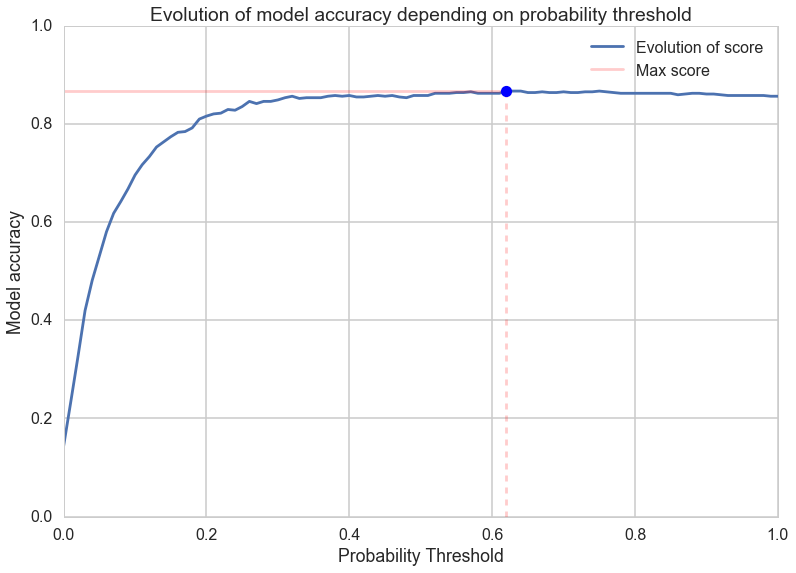

In [110]:
plt.plot(thresholds, scores, label = 'Evolution of score')
plt.plot([0, max_score_threshold], [max_score, max_score], color = 'r', alpha = 0.2, label = 'Max score')
plt.plot([max_score_threshold, max_score_threshold], [0, max_score], 'r--', alpha = 0.2)
plt.plot([max_score_threshold], [max_score], 'bo')
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Probability Threshold')
plt.ylabel('Model accuracy')
plt.title('Evolution of model accuracy depending on probability threshold')
plt.show()

Using this max value of accuracy, let's see what is the churn cost per costomer:

In [111]:
calculate_ccpc(predict_with_threshold(lr_est, X_test, max_score_threshold), Y_test)

135.15742128935531

This is the churn cost per customer of our LR estimator when it is build only considering the best accuracy possible.

Let's now use the churn cost per customer to find the best estimator.

In [88]:
lr_gs = GridSearchCV(lr_cf, param_grid = {'C': [10**i for i in range(-3, 3)], 'penalty': ['l1', 'l2']}, cv = 5, scoring = scorer_based_on_churn_cost_per_customer)

lr_gs.fit(X_train, Y_train)

lr_est = lr_gs.best_estimator_

This produced a new estimator with the following hyperparameters.

In [89]:
print "Using LR params %s help get the minimum CCpC" % lr_gs.best_params_

Using LR params {'penalty': 'l1', 'C': 1} help get the minimum CCpC


This is clearly a different estimator. But when we calculate the churn cost per customer, we get the following:

In [122]:
new_ccpc, t_with_lowest_ccpc = churn_cost_per_customer_and_threshold(lr_est, X_test, Y_test)
print "The lowest churn cost per customer is $%4.2f, using probability threshold of %0.2f" % (new_ccpc, t_with_lowest_ccpc)

The lowest churn cost per customer is $121.44, using probability threshold of 0.13


Clearly a lower churn cost per customer than the previous LR model. We've got this by lowering the probability threshold to 0.13! Nice job. What is the accuracy of this model?

In [124]:
Y_test_redicted = predict_with_threshold(lr_est, X_test, t_with_lowest_ccpc)
calculate_accuracy(Y_test_redicted, Y_test)

0.74512743628185907

Interesting! Even if we have an accuracy that is lower than our dummy esimator, we were able to reduce the churn cost per customer. This is a proof that in some data science problems, the best estimator is not the one with better accuracy (without considering technical considerations).

To summarize this sub-section, we built an estimator using cross validation that picks the best LR parameters (C and penalty) and also picks the probability threshold that lower the churn cost per customer. Using test dataset, we get a churn cost per customer of \$121

Can we build another estimator that beats LR estimator?

### 3.2. Random Forest

Let's do the same analysis as we did with Logistic Regression estimator, but this time with Random Forest estimator. As we did earlier, let's start bu creating an estimator that maximizes the accuracy.

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
rf_cf = RandomForestClassifier(n_jobs = -1)

rf_gs = GridSearchCV(rf_cf, param_grid = {'n_estimators': [100, 500, 1000]}, cv = 5)

rf_gs.fit(X_train, Y_train)

rf_est = rf_gs.best_estimator_

In [131]:
print "Using RF params %s produce the best model accuracy: %f" % (rf_gs.best_params_, rf_gs.best_score_)

Using RF params {'n_estimators': 1000} produce the best model accuracy: 0.930608


In [132]:
print "Accuracy on training data = %f" % rf_est.score(X_train, Y_train)
print "Accuracy on test data = %f" % rf_est.score(X_test, Y_test)

Accuracy on training data = 1.000000
Accuracy on test data = 0.944528


Nice job, Random Forest Classifier! But what about our churn cost per customer?

In [133]:
# Here, I'm considering a probability threshold of 0.5, as it was considered in the previous GridSearchCV
calculate_ccpc(predict_with_threshold(rf_est, X_test, 0.5), Y_test)

102.39880059970015

Good job! We've a higher accuracy and a lower CCpC than previous LR estimator.

Now, we are going to build another RF estimator, that is picked to reduce the churn cost per customer directly from the grid search cross validation.

In [137]:
rf_cf = RandomForestClassifier(n_jobs = -1)

rf_gs = GridSearchCV(rf_cf, param_grid = {'n_estimators': [100, 500]}, cv = 5, scoring = scorer_based_on_churn_cost_per_customer)

rf_gs.fit(X_train, Y_train)

rf_est = rf_gs.best_estimator_

_NOTA:_ Depending on your machine, the previous Grid Search can take a while. Here, I'm cheating! I'm only using three *n_estimators* values because I tried other values previousely and recursively.

In [138]:
print "Using RF params %s help get the CCpC" % rf_gs.best_params_

Using RF params {'n_estimators': 500} help get the CCpC


In [139]:
churn_cost_per_customer_and_threshold(rf_est, X_test, Y_test)

(95.427286356821583, 0.34000000000000002)

Waaaaaaay better! Using Random Forest estimator, with a probability threshold of 0.34 reduced the churn cost per customer bellow \$95.5

### 3.3. Naive Bayes

Another probabilistic estimator. Let's see if Naive Bayes classifier can do better that Random Forest classifier. Again, we are going to use Grid Search Cross Validation and Cost minimization to find the best estimator.

In [140]:
from sklearn.naive_bayes import GaussianNB

In [149]:
nb_cf = GaussianNB()

nb_gs = GridSearchCV(nb_cf, param_grid = {}, cv = 5)

nb_gs.fit(X_train, Y_train)

nb_est = nb_gs.best_estimator_

In [150]:
churn_cost_per_customer_and_threshold(nb_est, X_test, Y_test)

(139.28035982008996, 0.47999999999999998)

Deceiving result! We can't lower the churn cost per customer to lower than \$139. Let's now try using the scorer with CCpC

In [151]:
nb_cf = GaussianNB()

nb_gs = GridSearchCV(nb_cf, param_grid = {}, cv = 5, scoring = scorer_based_on_churn_cost_per_customer)

nb_gs.fit(X_train, Y_train)

nb_est = nb_gs.best_estimator_

In [152]:
churn_cost_per_customer_and_threshold(nb_est, X_test, Y_test)

(139.28035982008996, 0.47999999999999998)

Same result. Naive Bayes classification doesn't provide a better estimator.

***

## Step 4: Visualizing churn cost per customer of the three estimators

We tried three different classifiers in the previous step. Let's now visualize and discuss their characteristics.

We will work with the estimators that were built using our personal scorer. First, let's build the evolution of CCpC depending on the probability threshold.

In [168]:
thresholds = np.arange(0, 1.01, 0.01)

lr_ccpc = [calculate_ccpc(predict_with_threshold(lr_est, X_test, t), Y_test) for t in thresholds]
rf_ccpc = [calculate_ccpc(predict_with_threshold(rf_est, X_test, t), Y_test) for t in thresholds]
nb_ccpc = [calculate_ccpc(predict_with_threshold(nb_est, X_test, t), Y_test) for t in thresholds]

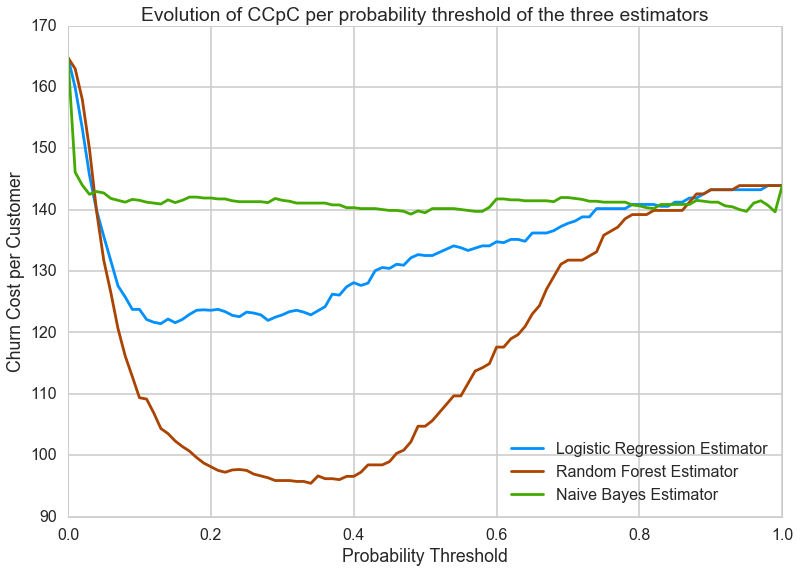

In [171]:
plt.plot(thresholds, lr_ccpc, color = '#0090ff', label = "Logistic Regression Estimator")
plt.plot(thresholds, rf_ccpc, color = '#aa4400', label = "Random Forest Estimator")
plt.plot(thresholds, nb_ccpc, color = '#44aa00', label = "Naive Bayes Estimator")
plt.legend(loc = 'lower right')
plt.xlabel('Probability Threshold')
plt.ylabel('Churn Cost per Customer')
plt.title('Evolution of CCpC per probability threshold of the three estimators')
plt.show()

Clearly, Random Forest estimator provides the best reduction of churn cost per customer. The lowest value is reached at CCpC of $95.43 and probability threshold of 0.34

In [175]:
print "Min CCpC for RF estimator is $%3.2f" % np.min(rf_ccpc)
print "Corresponding probability threshold is %0.2f" % thresholds[np.argmin(rf_ccpc)]

Min CCpC for RF estimator is $95.43
Corresponding probability threshold is 0.34


In our study, we have 3333 customers. As we need \$95.43 for every customer in order to cover the customers churn, this means we need to have ~\$318,000 at hand to cover churn costs. Not predicting churns (not having any predictor) will require ~\$480,000 at hand to cover the same population potential churns! This means a reduction of cost of ~\$48.50 per customer for the company.

***

## Conclusion

In this study, we showed how important it is to use the cost reduction of customer churns as a performance measure of the estimator, rather than just using the accuracy of the churn estimator. This led to completely different estimators, that perform completely differently. In a business objective point of view, using cost reduction takes more sense.

This shows how important it is to have domain knowledge in order to better discuss the objectives and explain results.

Using our churn predictor, the company makes \$48.50 saving per customer! If the company has 10,000,000 customers, and using our estimator, it could save \$485M!